# ML Feature engineering - SelectKbest

In [1091]:
%matplotlib inline
%run ../talibref.py
%run ensemble.py
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [1092]:
'''
input:
signal_column: name of the column that indicates the signal,  1 for long signal or 0 for short signal
price_column: name of the column responding to order execution price, default to close
commision: deduct commission for each transaction if True, default to False
strategy: list of 0 or/and 1, 0 for short,  and 1 for long.  
          can be any of these four value [], [0], [1], [1,0], 
output: 
balance, profit, ROI, balance_over_time, signals_over_time
'''
def evaluate_profit(df, start_date, end_date, intitial_balance, signal_column, price_column='close', commission=False, strategy=[0,1]):
    long_ = 1 in strategy
    short_ = 0 in strategy
    
    prev_price = 0
    perf_tol1 = 0.015
    perf_tol2 = 0.03
    perf_1d = 0
    
    df = df[(df.date>=start_date) & (df.date<=end_date)].sort('date').reset_index(drop=True)
    
    balance_over_time = []
    signals ={0:[], 1:[]}
    
    balance = intitial_balance
    current_position = -1 #1 for long position, 0 for short
    pos_quantity = 0 # current position quantity
    pos_price = 0 #current position price

    #iterate from first to n-1 row, as we want to close our position on the last day.
    for index, row in df.head(-1).iterrows():
        new_position = row[signal_column]
        current_price = row[price_column]
                
        # Set Performance
        if prev_price == 0:
            prev_price = current_price
            
        prev2_price = prev_price/(perf_1d+1)
        perf_2d = (current_price - prev2_price)/prev2_price
        perf_1d = (current_price - prev_price)/prev_price
        
        # Check Performance
        if (new_position != current_position) and (signal_column != 'result_baseline'):
            if (new_position == 1 and perf_1d < -perf_tol1) or (new_position == 0 and perf_1d > perf_tol1):
                new_position = current_position
            elif (new_position == 1 and perf_2d < -perf_tol2) or (new_position == 0 and perf_2d > perf_tol2):
                new_position = current_position

        prev_price = current_price

        # receive signal to reverse current position
        if current_position != new_position:
            # bullish market: close short position and open a long position
            if new_position == 1:
                #close the short position
                if short_:
                    balance = balance + pos_quantity * (2 * pos_price - current_price)
                    pos_quantity = 0
                    pos_price = 0
                    
                #open a long position 
                if long_:
                    pos_quantity = np.floor_divide(balance, current_price) 
                    balance = balance - current_price * pos_quantity
                    pos_price = current_price
                    
            # bearish market: close long position and open a short position
            else:
                #close the long position
                if long_:
                    balance = balance + current_price * pos_quantity
                    pos_quantity = 0
                    pos_price = 0
                    
                #open a short position
                if short_:
                    pos_quantity = np.floor_divide(balance, current_price) 
                    balance = balance - current_price * pos_quantity
                    pos_price = current_price
                    
            current_position = new_position       
            if commission:
                balance = balance - calculate_commission(current_price, pos_quantity)  
            
            signals[current_position].append((row['date'], current_price))   
        #hold position and do nothing
        else:
            pass
        balance_over_time.append((row['date'],balance+current_price * pos_quantity))
        
    #found open position on the last day, let's close it
    if pos_quantity != 0:
        # get price of last day
        current_price = df[price_column].tail(1).iloc[0]
        
        #close long position
        if long_ and current_position == 1:
            balance = balance + pos_quantity * current_price
            if commission:
                balance = balance - calculate_commission(current_price, pos_quantity)
        
        #close short position
        if short_ and current_position == 0:
            balance = balance + pos_quantity * (2 * pos_price - current_price)
            if commission:
                balance = balance - calculate_commission(current_price, pos_quantity)
            
    # capture date and balance on last day",
    balance_over_time.append((df['date'].tail(1).iloc[0],balance))
    signals[current_position].append((df['date'].tail(1).iloc[0], current_price))
    
    profit = balance - intitial_balance
    ROI = profit/intitial_balance
    
    return  balance, profit, ROI, balance_over_time, signals

### Get data

In [1093]:
#df=pd.read_csv("data/IYZ.csv")
ticker = 'IYW'
startdate=datetime.date(2010, 1, 1)
enddate=datetime.date.today()
df = generate_ticker_data(ticker, startdate, enddate)

Available data: Ticker(IYW) from 2000.05.19 to 2015.12.01
Usable data: Ticker(IYW) from 2001.03.07 to 2015.12.01 
Returned data: Ticker(IYW) from 2010.01.04 to 2015.12.01 
Save path: data/IYW_from_2010.01.04_2015.12.01.csv


In [1094]:
dftouse=df.copy()

### Feature Engineering

In [1095]:
IGNORE = ['date', 'result_1','close_1','perf_1','result_14','close_14','perf_14','results']

In [1096]:
INDICATORS=[]
for v in df.columns:
    l=df[v].unique()
    if len(l) <= 10 and v not in IGNORE:
        #print v, l
        INDICATORS.append(v)

In [1097]:
STANDARDIZABLE = []
for v in df.columns:
    if v not in INDICATORS and v not in IGNORE:
        #print v
        STANDARDIZABLE.append(v)

In [1098]:
################################################
# Code to add signals from other tickers
################################################

# Additional tickers to consider
moreTickers = [
               '^GSPC', #S&P500
               '^dji',  #Dow Jones Industrials
               '^IXIC', #Nasdaq
               'OIL'   #Oil price ETF
              ]

# Signals for additional tickers
STANDARDIZABLE_TO_ADD = ['roc']
INDICATORS_TO_ADD = ['sar_signal']


def addDataFromOtherTicker(tickerPlus):
    dfPlus = generate_ticker_data(tickerPlus, startdate, enddate)
    if df.shape == dfPlus.shape:
        dfPluss = dfPlus.copy()
        dfPluss = dfPluss[STANDARDIZABLE_TO_ADD+INDICATORS_TO_ADD]
        STANDARDIZABLE2 = STANDARDIZABLE_TO_ADD[:]
        INDICATORS2 = INDICATORS_TO_ADD[:]
        for p in STANDARDIZABLE2:
            renamed = p+'_'+tickerPlus
            dftouse[renamed]=dfPluss[p]*1.0
            STANDARDIZABLE.append(renamed)
        for p in INDICATORS2:
            renamed = p+'_'+tickerPlus
            dftouse[renamed]=dfPluss[p]
            INDICATORS.append(renamed)
    else:
        print "Data for additional tickers doesn't match data frame for sector of interest."

for tick in moreTickers:
    print "####### Loading data for "+tick+"...."
    addDataFromOtherTicker(tick)    
    time.sleep(0.5)
    
dftouse.head()

####### Loading data for ^GSPC....
Available data: Ticker(^GSPC) from 1950.01.03 to 2015.12.01
Usable data: Ticker(^GSPC) from 1962.05.28 to 2015.12.01 
Returned data: Ticker(^GSPC) from 2010.01.04 to 2015.12.01 
Save path: data/^GSPC_from_2010.01.04_2015.12.01.csv
####### Loading data for ^dji....
Available data: Ticker(^dji) from 1985.01.29 to 2015.12.01
Usable data: Ticker(^dji) from 1987.10.15 to 2015.12.01 
Returned data: Ticker(^dji) from 2010.01.04 to 2015.12.01 
Save path: data/^dji_from_2010.01.04_2015.12.01.csv
####### Loading data for ^IXIC....
Available data: Ticker(^IXIC) from 1971.02.05 to 2015.12.01
Usable data: Ticker(^IXIC) from 1973.11.26 to 2015.12.01 
Returned data: Ticker(^IXIC) from 2010.01.04 to 2015.12.01 
Save path: data/^IXIC_from_2010.01.04_2015.12.01.csv
####### Loading data for OIL....
Available data: Ticker(OIL) from 2006.08.16 to 2015.12.01
Usable data: Ticker(OIL) from 2007.06.05 to 2015.12.01 
Returned data: Ticker(OIL) from 2010.01.04 to 2015.12.01 
Sa

,date,open,high,low,close,volume,close_1,result_1,perf_1,close_14,result_14,perf_14,results,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_squeeze,bb_signalup,bb_signaldn,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal,roc_^GSPC,sar_signal_^GSPC,roc_^dji,sar_signal_^dji,roc_^IXIC,sar_signal_^IXIC,roc_OIL,sar_signal_OIL
0,2010-01-04,57.959999,58.639999,57.959999,58.490002,839500,58.400002,False,-0.001539,54.650002,False,-0.065652,0,58.821266,56.400501,53.979736,0.931579,8.584197,False,False,False,1,55.103843,50.939451,49.689076,1,1,54.934088,55.163104,54.687729,1,1,57.129425,1,25.595318,34.344404,14.198666,True,True,1,96,1,104.070198,0,0.967047,0.820124,0.146923,1,2.069180,1,77.163680,0,6.056210,0,69.456721,0,65.655670,0,-4.178189,0,323738.684607,1,68.252065,73.811019,0,74.199560,58.066520,1,0.159948,1,58.363333,63.376669,58.086668,63.653334,53.073332,68.666670,52.796667,1,3.367458,1,2.674556,1,5.888391,1,11.120401,1
1,2010-01-05,58.540001,58.639999,58.070000,58.400002,533400,57.990002,False,-0.007021,55.070000,False,-0.057021,0,59.073448,56.551501,54.029554,0.866483,8.919116,False,False,False,1,55.233104,51.038266,49.775752,1,1,55.057603,55.293977,54.853506,1,1,57.431539,1,26.731421,32.251229,13.333305,True,True,1,100,1,91.820847,0,0.985246,0.853149,0.132097,1,2.210421,1,78.400021,0,4.211279,0,68.387361,0,62.174984,0,-6.685153,0,350002.731221,1,62.175877,65.253897,0,59.847580,44.682380,1,0.162662,1,58.370000,63.390003,58.100002,63.660001,53.079999,68.680004,52.810001,1,3.088524,1,2.353882,1,4.386692,1,10.696517,1
2,2010-01-06,58.450001,58.580002,57.869999,57.990002,578900,57.770000,False,-0.003794,55.000000,False,-0.051561,0,59.199055,56.696501,54.193947,0.758436,8.827896,False,False,False,1,55.341217,51.130342,49.857486,1,1,55.152838,55.400863,54.976327,1,1,57.673231,1,27.300301,29.813769,14.454549,True,True,1,96,1,68.044885,0,0.955570,0.873633,0.081937,1,2.352947,1,72.429127,0,2.437734,0,63.584635,0,54.831713,0,-18.105766,0,206997.775002,1,69.047859,66.491934,0,0.000000,44.682380,1,0.165199,1,58.146668,62.943337,57.653336,63.436669,52.856667,68.233338,52.363335,1,2.072615,1,1.531956,1,2.834666,1,13.871370,1
3,2010-01-07,57.970001,57.970001,57.500000,57.770000,351800,58.209999,True,0.007616,55.340000,False,-0.042063,1,59.218125,56.849501,54.480876,0.694311,8.332965,False,False,False,1,55.436464,51.218284,49.936217,1,1,55.237835,55.488469,55.088032,1,1,58.639999,0,26.987320,28.228161,17.701692,True,True,1,68,1,30.369543,0,0.903880,0.879682,0.024198,1,2.353796,1,66.157736,0,1.368658,0,61.104844,0,54.764768,0,-24.233955,0,146348.867587,1,48.073470,59.765736,0,0.000000,19.949193,1,0.167402,1,57.746667,62.143336,56.853335,63.036668,52.456666,67.433337,51.563334,1,2.117129,1,1.356251,1,2.103288,1,11.928517,1
4,2010-01-08,57.639999,58.230000,57.470001,58.209999,593600,57.930000,False,-0.004810,53.799999,False,-0.075760,0,59.311038,57.000501,54.689964,0.761735,8.107076,False,False,False,1,55.545230,51.310890,50.018543,1,1,55.365102,55.590904,55.215207,1,1,58.617199,0,27.038391,28.716233,16.257476,True,True,1,68,1,44.488854,0,0.888181,0.881382,0.006799,1,2.356368,1,73.006454,0,1.552685,0,64.118817,0,62.512323,0,-13.354033,0,287165.055712,1,42.965511,53.362280,0,36.087375,12.029125,1,0.169476,1,57.970000,62.590002,57.300001,63.260001,52.679999,67.880003,52.010000,1,2.176533,1,1.449872,1,2.094166,1,8.644949,1


In [1099]:
dftouse['date'] = pd.to_datetime(dftouse['date'])
mask = (dftouse.date < '2015-01-01').values
mask.shape, mask.sum()

((1489,), 1258)

#### 1.2 Standardize the data

Use the mask to compute the training and test parts of the dataframe. Use `StandardScaler` from `sklearn.preprocessing` to "fit" the columns in `STANDARDIZABLE` on the training set. Then use the resultant estimator to transform both the training and the test parts of each of the columns in the dataframe, replacing the old unstandardized values in the `STANDARDIZABLE` columns of `dftouse` by the new standardized ones.

In [1100]:
#your code here
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(dftouse[mask][STANDARDIZABLE])
dftouse[STANDARDIZABLE] = scaler.transform(dftouse[STANDARDIZABLE])
dftouse.head()

,date,open,high,low,close,volume,close_1,result_1,perf_1,close_14,result_14,perf_14,results,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_squeeze,bb_signalup,bb_signaldn,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal,roc_^GSPC,sar_signal_^GSPC,roc_^dji,sar_signal_^dji,roc_^IXIC,sar_signal_^IXIC,roc_OIL,sar_signal_OIL
0,2010-01-04,-1.142781,-1.123961,-1.104804,-1.103787,1.337484,58.400002,False,-0.001539,54.650002,False,-0.065652,0,-1.260669,-1.255070,-1.242312,1.052971,0.458003,False,False,False,1,-1.348428,-1.617620,-1.678400,1,1,-1.419538,-1.344623,-1.350521,1,1,-1.142387,1,0.270205,1.313184,-1.305396,True,True,1,1.134579,1,0.755003,0,0.923030,0.784319,0.583108,1,1.072956,1,1.218555,0,1.683402,0,1.216279,0,0.955568,0,1.063089,0,0.686016,1,0.353547,0.608103,0,0.487262,0.124580,1,1.172566,1,-1.111213,-1.028652,-0.915626,-1.214656,-0.953616,-1.086101,-0.768278,1,1.022709,1,0.854181,1,1.648852,1,2.097356,1
1,2010-01-05,-1.100308,-1.123961,-1.096769,-1.110372,0.583723,57.990002,False,-0.007021,55.070000,False,-0.057021,0,-1.241861,-1.243796,-1.238610,0.855256,0.562565,False,False,False,1,-1.338482,-1.609522,-1.671148,1,1,-1.409826,-1.334189,-1.337307,1,1,-1.120506,1,0.394498,1.023140,-1.414303,True,True,1,1.197902,1,0.639578,0,0.947191,0.831596,0.524466,1,1.161113,1,1.283000,0,1.119975,0,1.126145,0,0.633974,0,0.983438,0,0.769783,1,0.125212,0.259536,0,0.142227,-0.281263,1,1.201932,1,-1.110725,-1.027714,-0.914703,-1.214167,-0.953156,-1.085195,-0.767413,1,0.922154,1,0.730416,1,1.176547,1,2.019937,1
2,2010-01-06,-1.106899,-1.128352,-1.111379,-1.140372,0.695765,57.770000,False,-0.003794,55.000000,False,-0.051561,0,-1.232493,-1.232971,-1.226394,0.527085,0.534086,False,False,False,1,-1.330162,-1.601975,-1.664310,1,1,-1.402338,-1.325667,-1.327517,1,1,-1.103001,1,0.456736,0.685390,-1.273193,True,True,1,1.134579,1,0.415537,0,0.907794,0.860922,0.326054,1,1.250072,1,0.971763,0,0.578349,0,0.721333,0,-0.044498,0,0.620587,0,0.313677,1,0.383452,0.309966,0,-1.296565,-0.281263,1,1.229380,1,-1.127065,-1.059154,-0.945609,-1.230539,-0.968580,-1.115526,-0.796365,1,0.555921,1,0.413191,1,0.688413,1,2.599800,1
3,2010-01-07,-1.142048,-1.172997,-1.138407,-1.156470,0.136539,58.209999,True,0.007616,55.340000,False,-0.042063,1,-1.231071,-1.221548,-1.205072,0.332317,0.379568,False,False,False,1,-1.322833,-1.594768,-1.657723,1,1,-1.395654,-1.318682,-1.318613,1,1,-1.032982,0,0.422495,0.465677,-0.864533,True,True,1,0.691318,1,0.060522,0,0.839171,0.869582,0.097663,1,1.250601,1,0.644863,0,0.251862,0,0.512316,0,-0.050684,0,0.425884,0,0.120241,1,-0.404737,0.035980,0,-1.296565,-1.031239,1,1.253205,1,-1.156329,-1.115465,-1.000961,-1.259863,-0.996204,-1.169850,-0.848220,1,0.571968,1,0.345377,1,0.458384,1,2.244953,1
4,2010-01-08,-1.166214,-1.153968,-1.140598,-1.124275,0.731964,57.930000,False,-0.004810,53.799999,False,-0.075760,0,-1.224141,-1.210274,-1.189535,0.537105,0.309045,False,False,False,1,-1.314464,-1.587178,-1.650836,1,1,-1.385647,-1.310515,-1.308476,1,1,-1.034633,0,0.428082,0.533308,-1.046291,True,True,1,0.691318,1,0.193568,0,0.818330,0.872015,0.028841,1,1.252207,1,1.001857,0,0.308063,0,0.766358,0,0.665142,0,0.771557,0,0.569366,1,-0.596687,-0.224859,0,-0.428991,-1.271397,1,1.275641,1,-1.139990,-1.084025,-0.970056,-1.243490,-0.980781,-1.139519,-0.819268,1,0.593383,1,0.381511,1,0.455515,1,1.645234,1


We create a list `lcols` of the columns we will use in our classifier. This list should not contain the response `RESP`. How many features do we have?

In [1101]:
#lcols=list(dftouse.columns)
#lcols.remove(u'results')
lcols=[]
for c in list(dftouse.columns):
    if c not in IGNORE: 
        lcols.append(c)
print len(lcols)

78


### EDA for the data

We create a variable `ccols` which contains all variables not in our indicators list

In [1102]:
ccols=[]
for c in lcols:
    if c not in INDICATORS and c not in IGNORE:
        ccols.append(c)
print len(ccols), len(INDICATORS)

48 30


In [1103]:
def cv_optimize(clf, parameters, X, y, n_folds, score_func):
    fitmodel = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func, n_jobs=2)
    fitmodel.fit(X, y)
    return fitmodel.best_estimator_

In [1104]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=7):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        #print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        #print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    #print "############# based on standard predict ################"
    #print "Accuracy on training data: %0.2f" % (training_accuracy)
    #print "Accuracy on test data:     %0.2f" % (test_accuracy)
    #print confusion_matrix(ytest, clf.predict(Xtest))
    #print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [1105]:
X=dftouse[lcols].values
y=dftouse['results'].values
Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]  
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [1106]:
print "whole data set", dftouse['results'].mean()
print "training set", dftouse['results'][mask].mean(), "test set", dftouse['results'][~mask].mean()

whole data set 0.43922095366
training set 0.436406995231 test set 0.454545454545


#####our data is not very asymmetric, but we might still want to balance the trainset

### Balancing train set to test set for training, 
### intended to be used with SVM only

In [1107]:
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg

ineg = np.random.choice(jtrain[ytrain==0], n_pos, replace=False)
alli=np.concatenate((jtrain[ytrain==1], ineg))
Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
print Xtrain_new.shape, ytrain_new.shape

reuse_split_balanced=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

549 709
(1098, 78) (1098,)


## Test all classifiersres using SelectKbest

In [1108]:
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def evaluate(clf):
    clf.fit(Xtrain,ytrain)
    training_accuracy = accuracy_score(ytrain, clf.predict(Xtrain))
    test_accuracy = accuracy_score(ytest, clf.predict(Xtest))
    df_pred = df[~mask].reset_index(drop=True)
    df_pred['pred_result'] = clf.predict(Xtest)
    df_pred['result_baseline'] = np.ones(df_pred.shape[0])
    _,_,ROI_base,_,_ = evaluate_profit(df_pred, startdate, enddate, 10000, 'result_baseline', 'close', True, [1])
    _,_,ROI_long,bal_over_time,_ = evaluate_profit(df_pred, startdate, enddate, 10000, 'pred_result', 'close', True, [1])
    _,_,ROI_lgst,_,signals = evaluate_profit(df_pred, startdate, enddate, 10000, 'pred_result', 'close', True, [1,0])
    return training_accuracy, test_accuracy, ROI_base, ROI_long, ROI_lgst, signals,bal_over_time

def print_result(clfpipe):     
    print "Number of features: {0}".format(clfpipe.get_params()['selectk__k'])
    print "Features: {0}".format(np.array(lcols)[clfpipe.named_steps['selectk'].get_support()].tolist())
    r = evaluate(clfpipe)
    print "train accuracy: {0}".format(r[0])
    print "test accuracy: {0}".format(r[1])
    print "ROI baseline: {0}".format(r[2])
    print "ROI long-only: {0}".format(r[3])
    print "ROI long-short: {0}".format(r[4])

In [1109]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


In [1110]:
%%time
max_number_featrues = 20
Results={}
scoring_func="accuracy"


print "#############====================== Log Regression =====================#############"
selectk = SelectKBest(score_func=f_regression)
pipeLR = Pipeline([('selectk', selectk), ('LR', LogisticRegression(penalty="l1"))])
pipeLR, _,_,_,_  = do_classify(pipeLR, {"selectk__k":range(1,max_number_featrues+1), 
                                        "LR__C": [1e-3, 1e-2, 1e-1, 1, 1e2],
                                        "LR__random_state": [111]}, 
                               dftouse,lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)

print pipeLR.get_params()['LR__C']
print_result(pipeLR)
Results["log_regression"] = evaluate(pipeLR)[0:5]

#############====================== Log Regression =====================#############
0.1
Number of features: 5
Features: ['bb_pct', 'cci', 'rsi', 'willr', 'stoch_slowk']
train accuracy: 0.673290937997
test accuracy: 0.731601731602
ROI baseline: 0.071128
ROI long-only: 0.0329248043
ROI long-short: -0.0142743922
CPU times: user 18 s, sys: 1.56 s, total: 19.6 s
Wall time: 25.9 s


In [1111]:
%%time
print "#############====================== RBF SVM ===========================#############"
pipesvm2 = Pipeline([('selectk', selectk), ('svm2', SVC())])
pipesvm2,_,_,_,_  = do_classify(pipesvm2, {"selectk__k":[2,3,4,5,6,7,9,12,18,25], 
                                            "svm2__C": [1e-2,1e-1,1,1e2,1e4,1e5,1e6,1e7, 1e8,1e9], 
                                            "svm2__gamma": [ 1e-7,1e-8, 1e-9, 1e-10],
                                            "svm2__random_state": [111]}, 
                                 dftouse,lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)
print pipesvm2.get_params()['svm2__C'], pipesvm2.get_params()['svm2__gamma']
print_result(pipesvm2)
Results["RBF_SVM"] = evaluate(pipesvm2)[0:5]

#############====================== RBF SVM ===========================#############
1000000000.0 1e-10
Number of features: 7
Features: ['bb_pct', 'plus_di', 'cci', 'rsi', 'ult_osc', 'willr', 'stoch_slowk']
train accuracy: 0.671701112878
test accuracy: 0.735930735931
ROI baseline: 0.071128
ROI long-only: 0.0595720007
ROI long-short: 0.0391310037
CPU times: user 1min 4s, sys: 5.39 s, total: 1min 9s
Wall time: 2min 45s


In [1112]:
%%time
print "#############====================== Random Forest =====================#############"
pipeRF = Pipeline([('selectk', selectk), ('RF', RandomForestClassifier())])
pipeRF,_,_,_,_  = do_classify(pipeRF, {"selectk__k": [5,6,7,8,9,10],
                                       "RF__max_depth": [3,5,7], 
                                       "RF__n_estimators": [5,10,20],
                                       "RF__max_features": [1,2,3],
                                       "RF__random_state": [111]}, 
                              dftouse, lcols, u'results', 1, reuse_split=reuse_split,score_func=scoring_func)

print pipeRF.get_params()['RF__max_depth'], pipeRF.get_params()['RF__n_estimators'], pipeRF.get_params()['RF__max_features']
print_result(pipeRF)
Results["Random_forest"] = evaluate(pipeRF)[0:5]

#############====================== Random Forest =====================#############
3 20 2
Number of features: 9
Features: ['bb_pct', 'plus_di', 'minus_di', 'cci', 'roc', 'rsi', 'ult_osc', 'willr', 'stoch_slowk']
train accuracy: 0.690779014308
test accuracy: 0.701298701299
ROI baseline: 0.071128
ROI long-only: 0.0885920247
ROI long-short: 0.0966210407
CPU times: user 27.8 s, sys: 2.36 s, total: 30.1 s
Wall time: 52.2 s


In [1113]:
%%time
print "#############====================== Extra Trees= =====================#############"
pipeET = Pipeline([('selectk', selectk), ('ET', ExtraTreesClassifier())])
pipeET, _,_,_,_  = do_classify(pipeET, {"selectk__k": [5,6,7,8,9,10,15],
                                        "ET__max_depth": [1,2,3,5,7,10,15], 
                                        "ET__n_estimators": [3,5,10],
                                        "ET__max_features": [1,2,3],
                                        "ET__random_state": [111]}, 
                               dftouse, lcols, u'results', 1, reuse_split=reuse_split,score_func=scoring_func)
print "ET__max_depth: {0}".format(pipeET.get_params()['ET__max_depth']) 
print "ET__n_estimators: {0}".format(pipeET.get_params()['ET__n_estimators']) 
print "ET__max_features: {0}".format(pipeET.get_params()['ET__max_features']) 
print_result(pipeET)
Results["Extra_Trees"] = evaluate(pipeET)[0:5]

#############====================== Extra Trees= =====================#############
ET__max_depth: 1
ET__n_estimators: 10
ET__max_features: 3
Number of features: 8
Features: ['bb_pct', 'plus_di', 'cci', 'roc', 'rsi', 'ult_osc', 'willr', 'stoch_slowk']
train accuracy: 0.677265500795
test accuracy: 0.714285714286
ROI baseline: 0.071128
ROI long-only: 0.0923540343
ROI long-short: 0.1059950613
CPU times: user 1min 16s, sys: 6.5 s, total: 1min 22s
Wall time: 1min 56s


In [1114]:
%%time
print "#############====================== Gaussian NB ==========================#############"
pipeNB = Pipeline([('selectk', selectk), ('NB', GaussianNB())])
pipeNB,_,_,_,_ = do_classify(pipeNB, {"selectk__k":range(1,max_number_featrues+1)}, 
                             dftouse, lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)
print_result(pipeNB)
Results["Gaussian_NB"] = evaluate(pipeNB)[0:5]

#############====================== Gaussian NB ==========================#############
Number of features: 8
Features: ['bb_pct', 'plus_di', 'cci', 'roc', 'rsi', 'ult_osc', 'willr', 'stoch_slowk']
train accuracy: 0.674085850556
test accuracy: 0.735930735931
ROI baseline: 0.071128
ROI long-only: 0.0575600587
ROI long-short: 0.0365181201
CPU times: user 4.31 s, sys: 408 ms, total: 4.72 s
Wall time: 5.81 s


In [1115]:
#%%time
#print "#############====================== Gradient Boosting ====================#############"
#pipeGB = Pipeline([('selectk', selectk), ('GB', GradientBoostingClassifier())])
#pipeGB, _,_,_,_  = do_classify(pipeGB, {"selectk__k":range(1,max_number_featrues+1), 
#                                        "GB__n_estimators": [5,10,20,40],
#                                        "GB__learning_rate": [0.1,0.5,1.0],
#                                        "GB__random_state": [111]}, 
#                               dftouse,lcols, u'results',1, reuse_split=reuse_split)
#print pipeGB.get_params()['GB__n_estimators'], pipeGB.get_params()['GB__learning_rate']
#print_result(pipeGB)
#Long_ROI_result["Gradient_bossting"] = evaluate(pipeGB)[3]
#Test_set_accuracies["Gradient_bossting"] = evaluate(pipeGB)[1]

In [1116]:
print "#############====================== ENSEMBLE ==========================#############"
eclf = EnsembleClassifier(clfs=[pipeLR, pipesvm2, pipeRF, pipeET, pipeNB], voting='hard')
r = evaluate(eclf)
Results["Ensemble"] = r[0:5]
print "train accuracy: {0}".format(r[0])
print "test accuracy: {0}".format(r[1])
print "ROI baseline: {0}".format(r[2])
print "ROI long-only: {0}".format(r[3])
print "ROI long-short: {0}".format(r[4])

#############====================== ENSEMBLE ==========================#############
train accuracy: 0.682034976153
test accuracy: 0.748917748918
ROI baseline: 0.071128
ROI long-only: 0.0854520176
ROI long-short: 0.0891030372


In [1117]:
print "---Test accuracy results---"
for key, value in Results.iteritems():
    print key, value[1]

---Test accuracy results---
RBF_SVM 0.735930735931
Extra_Trees 0.714285714286
Gaussian_NB 0.735930735931
log_regression 0.731601731602
Random_forest 0.701298701299
Ensemble 0.748917748918


In [1118]:
print "ROI baseline: {0}".format(evaluate(pipeNB)[2])
print "---Long ROI results---"
for key, value in Results.iteritems():
    print key, value[3]

ROI baseline: 0.071128
---Long ROI results---
RBF_SVM 0.0595720007
Extra_Trees 0.0923540343
Gaussian_NB 0.0575600587
log_regression 0.0329248043
Random_forest 0.0885920247
Ensemble 0.0854520176


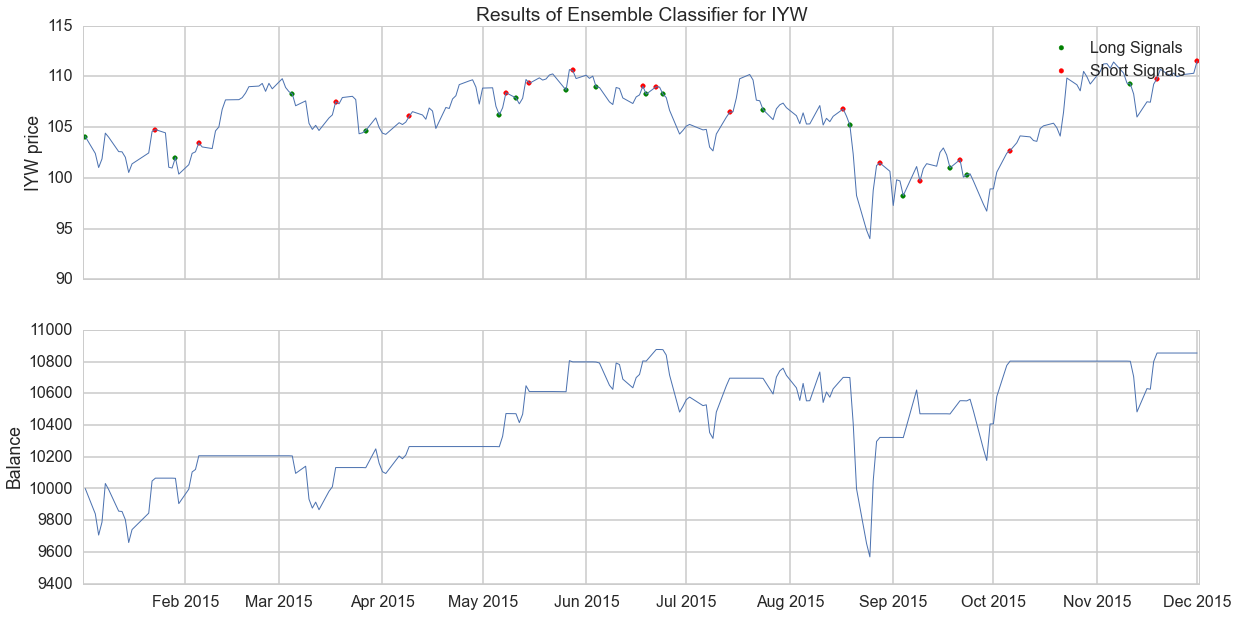

In [1119]:
def plot_signal(model, title):
    fig, (ax0,ax1) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10),sharex=True)
    ax0.plot(df.date[~mask], df.close[~mask], lw=1)
    short_days=zip(*evaluate(model)[5][0])[0]
    short_prices=zip(*evaluate(model)[5][0])[1]
    long_days=zip(*evaluate(model)[5][1])[0]
    long_prices=zip(*evaluate(model)[5][1])[1]
    ax0.scatter(long_days, long_prices, color='g', label="Long Signals") 
    ax0.scatter(short_days, short_prices, color='r', label="Short Signals")
    ax0.legend(frameon=False, loc='upper right')
    ax0.set_title(title)
    ax0.set_ylabel(ticker + " price")
    
    ax1.plot(zip(*evaluate(model)[6])[0], zip(*evaluate(model)[6])[1], lw=1)
    ax1.set_ylabel("Balance")
plot_signal(eclf, 'Results of Ensemble Classifier for '+ticker)

In [1120]:
# Save results for this ticker to a JSON file
import json
fd = open("../ML_results_E/"+ticker+".json","w")
json.dump(Results, fd)
fd.close()

In [1121]:
# Load results from all files
import glob
result_files = glob.glob("../ML_results_E/*.json")
print result_files
accuracies_all= {}
ROI_diff_all={}
for aFile in result_files:
    file_tickr = aFile[16:19]
    #print file_tickr
    with open(aFile, "r") as fd:
        result_dict = json.load(fd)
        models_acc = {}
        models_ROI_diff = {}
        for key, value in result_dict.iteritems():
            models_acc[key] =  value[1]
            models_ROI_diff[key] =  value[3]-value[2]
            accuracies_all[file_tickr] =  models_acc
            ROI_diff_all[file_tickr] =  models_ROI_diff
accuracies_all=pd.DataFrame(accuracies_all)
ROI_diff_all=pd.DataFrame(ROI_diff_all)

['../ML_results_E/ITB.json', '../ML_results_E/IYE.json', '../ML_results_E/IYF.json', '../ML_results_E/IYH.json', '../ML_results_E/IYJ.json', '../ML_results_E/IYM.json', '../ML_results_E/IYR.json', '../ML_results_E/IYW.json', '../ML_results_E/IYZ.json']


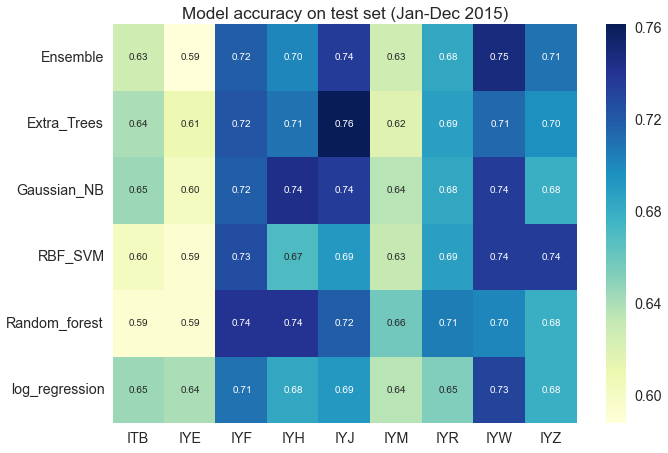

In [1122]:
sns.set_context("talk", font_scale=1.1, rc={"lines.linewidth": 2.5})
ax = sns.heatmap(accuracies_all, annot=True, fmt='.2f',cmap="YlGnBu")
ax.set_title("Model accuracy on test set (Jan-Dec 2015)")

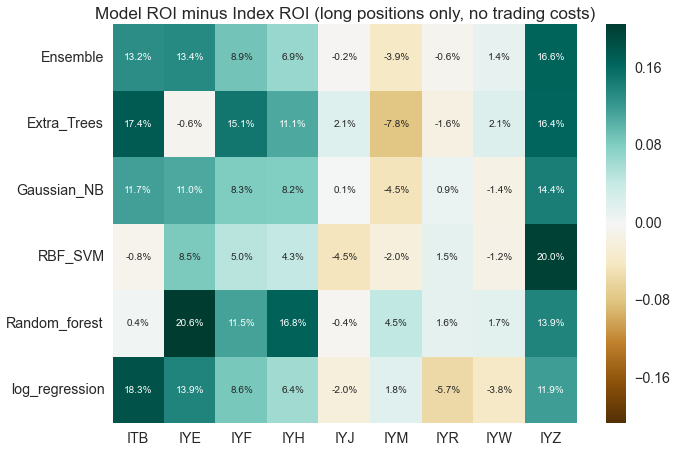

In [1123]:
ax2 = sns.heatmap(ROI_diff_all, annot=True, fmt='.1%',cmap="BrBG")
ax2.set_title("Model ROI minus Index ROI (long positions only, no trading costs)")